Fine-tuning RoBERTa by Huggingface for Fake News classification. 

In [1]:
data_path = '<data_path>'
output_path = 'output'

In [2]:
import os
import gc
import glob
import torch
import pickle
import joblib
from tqdm.auto import tqdm

from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import numpy as np
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/nlp

/content/drive/MyDrive/nlp


In [5]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [6]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [7]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [8]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [9]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [10]:
from dont_patronize_me import DontPatronizeMe

In [11]:
dpm = DontPatronizeMe('.', '.')

In [12]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [13]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [14]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [15]:
teids.head()

,par_id,label
0,4046,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,"[1, 0, 0, 0, 0, 0, 0]"


In [16]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

Rebuild training set (Task 1)

In [17]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [18]:
trdf1 = pd.DataFrame(rows2)

In [19]:
trdf1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...,...
8370,8380,Rescue teams search for survivors on the rubbl...,"[0, 0, 0, 0, 0, 0, 0]"
8371,8381,The launch of ' Happy Birthday ' took place la...,"[0, 0, 0, 0, 0, 0, 0]"
8372,8382,"The unrest has left at least 20,000 people dea...","[0, 0, 0, 0, 0, 0, 0]"
8373,8383,You have to see it from my perspective . I may...,"[0, 0, 0, 0, 0, 0, 0]"


Rebuild test set (Task 1)

In [20]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [21]:
tedf1 = pd.DataFrame(rows2)

In [22]:
trdf1.label = trdf1.label.apply(literal_eval)
tedf1.label = tedf1.label.apply(literal_eval)

In [23]:
# downsample negative instances

all_negs = trdf1[trdf1.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf1[trdf1.label.apply(lambda x:sum(x) > 0)]

trdf1 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [24]:
!pip install transformers
!pip install -U torchtext==0.8.0

     |████████████████████████████████| 4.0 MB 25.5 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
     |████████████████████████████████| 880 kB 55.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=782e4f0e6ae815ff36c0da214a6237014f309a58540fe644330ba41ad2d4ac40
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.9 MB 27.7 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [27]:
trdf1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...,...
1186,434,""""""" I was absolutely useless at school , hopel...","[0, 0, 0, 0, 0, 0, 0]"
1187,435,I also noticed the change in socio-economic le...,"[0, 0, 0, 0, 0, 0, 0]"
1188,436,"Can Donald Trump win ? It 's possible , but ce...","[0, 0, 0, 0, 0, 0, 0]"
1189,437,He added that any introduction of new law must...,"[0, 0, 0, 0, 0, 0, 0]"


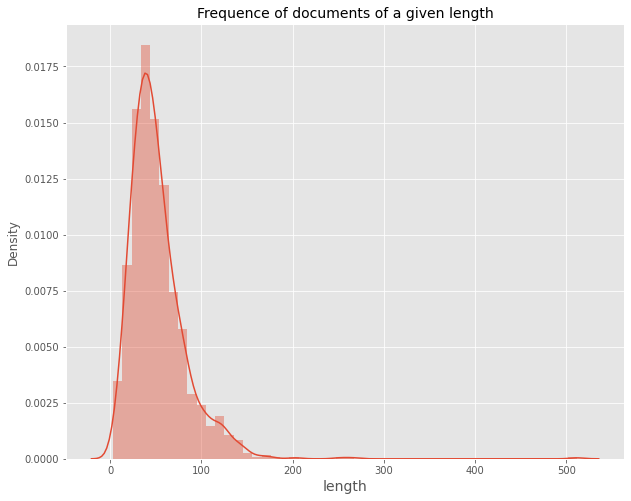

In [28]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
trdf1['length'] = trdf1['text'].apply(lambda x: len(x.split()))
sns.distplot(trdf1[trdf1['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [29]:
trdf1['label1'] = [d[0] for d in trdf1['label']]
trdf1['label2'] = [d[1] for d in trdf1['label']]
trdf1['label3'] = [d[2] for d in trdf1['label']]
trdf1['label4'] = [d[3] for d in trdf1['label']]
trdf1['label5'] = [d[4] for d in trdf1['label']]
trdf1['label6'] = [d[5] for d in trdf1['label']]
trdf1['label7'] = [d[6] for d in trdf1['label']]

In [30]:
tedf1['label1'] = [d[0] for d in tedf1['label']]
tedf1['label2'] = [d[1] for d in tedf1['label']]
tedf1['label3'] = [d[2] for d in tedf1['label']]
tedf1['label4'] = [d[3] for d in tedf1['label']]
tedf1['label5'] = [d[4] for d in tedf1['label']]
tedf1['label6'] = [d[5] for d in tedf1['label']]
tedf1['label7'] = [d[6] for d in tedf1['label']]

In [31]:
# Save preprocessed data, cropped to max length of the model.
trdf1['text'] = trdf1['text'].apply(lambda x: " ".join(x.split()[:512]))
trdf1.to_csv(f"prep_news.csv")

In [32]:
trdf1

,par_id,text,label,length,label1,label2,label3,label4,label5,label6,label7
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]",36,1,0,0,1,0,0,0
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]",6,0,1,0,0,0,0,0
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]",72,1,0,0,0,0,1,0
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]",45,0,0,0,1,0,0,0
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]",49,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1186,434,""""""" I was absolutely useless at school , hopel...","[0, 0, 0, 0, 0, 0, 0]",20,0,0,0,0,0,0,0
1187,435,I also noticed the change in socio-economic le...,"[0, 0, 0, 0, 0, 0, 0]",27,0,0,0,0,0,0,0
1188,436,"Can Donald Trump win ? It 's possible , but ce...","[0, 0, 0, 0, 0, 0, 0]",105,0,0,0,0,0,0,0
1189,437,He added that any introduction of new law must...,"[0, 0, 0, 0, 0, 0, 0]",31,0,0,0,0,0,0,0


In [33]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [34]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [35]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'text' : ('text', text_field), 'label1' : ('label1', label_field),
          'label2' : ('label2', label_field),'label3' : ('label3', label_field),
          'label4' : ('label4', label_field),'label5' : ('label5', label_field),
          'label6' : ('label6', label_field),'label7' : ('label7', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"prep_news.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=False)

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [36]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [37]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base', return_dict = False)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 7)
        self.sig = torch.nn.Sigmoid()
        
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        x = self.sig(x)
        return x  

In [38]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, y1,y2,y3,y4,y5,y6,y7), _ in train_iter:
            target = torch.stack((y1,y2,y3,y4,y5,y6,y7)).T
            optimizer.zero_grad()
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            target = target.to(torch.float)
            loss = torch.nn.functional.binary_cross_entropy(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, y1,y2,y3,y4,y5,y6,y7), _ in valid_iter:
                        target = torch.stack((y1,y2,y3,y4,y5,y6,y7)).T
                        target = target.to(torch.float)
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.functional.binary_cross_entropy(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [39]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = "output/"):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, y1,y2,y3,y4,y5,y6,y7), _ in train_iter:
            target = torch.stack((y1,y2,y3,y4,y5,y6,y7)).T
            
            mask = (source != PAD_INDEX).type(torch.uint8)
            optimizer.zero_grad()
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            target = target.to(torch.float)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.functional.binary_cross_entropy(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, y1,y2,y3,y4,y5,y6,y7), _ in valid_iter:
                        target = torch.stack((y1,y2,y3,y4,y5,y6,y7)).T
                        target = target.to(torch.float)
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.functional.binary_cross_entropy(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [78]:
# Main training loop
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 16
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=4e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/6], global step [53/318], PT Loss: 0.5176, Val Loss: 0.4665
Epoch [2/6], global step [106/318], PT Loss: 0.4484, Val Loss: 0.4608
Epoch [3/6], global step [159/318], PT Loss: 0.4371, Val Loss: 0.4602
Epoch [4/6], global step [212/318], PT Loss: 0.4402, Val Loss: 0.4621
Epoch [5/6], global step [265/318], PT Loss: 0.4369, Val Loss: 0.4622
Epoch [6/6], global step [318/318], PT Loss: 0.4372, Val Loss: 0.4629
Pre-training done!
======================= Start training =================================
Epoch [1/12], global step [53/636], Train Loss: 0.4364, Valid Loss: 0.4621
Epoch [2/12], global step [106/636], Train Loss: 0.4273, Valid Loss: 0.4245
Epoch [3/12], global step [159/636], Train Loss: 0.3952, Valid Loss: 0.4000
Epoch [4/12], global step [212/636], Train Loss: 0.3647, Valid Loss: 0.3864
Epoch [5/12], global step [265/636], Train Loss: 0.3430, Valid Loss: 0.3807
Epoch [6/12], global step [318/636], 

In [41]:
output_path = 'output'

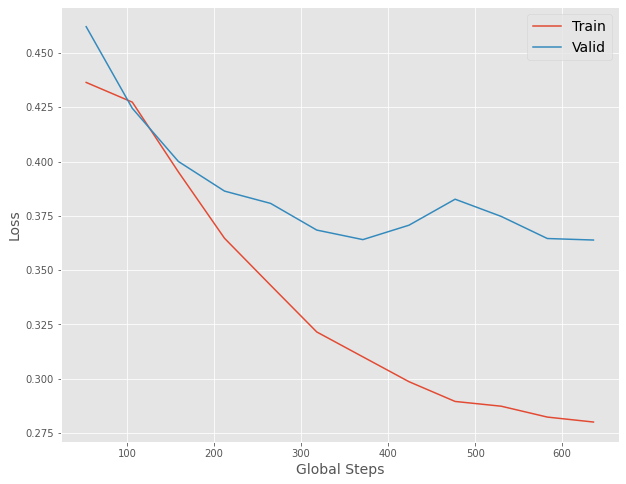

In [79]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

In [49]:
from sklearn.metrics import multilabel_confusion_matrix


In [82]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, y1,y2,y3,y4,y5,y6,y7), _ in test_loader:
                target = torch.stack((y1,y2,y3,y4,y5,y6,y7)).T
                target = target.to(torch.float)
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                
                y_pred.extend(torch.round(output).tolist())
                y_true.extend(target.tolist())
    
    #print('Classification Report:')
    #print(y_true)
    #print(y_pred)

    #print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    '''
    cm = multilabel_confusion_matrix(y_true, y_pred)
    for i in range(7):
      ax = plt.subplot()

      sns.heatmap(cm[i,:,:], annot=True, ax = ax, cmap='Blues', fmt="d")

      ax.set_title('Confusion Matrix')

      ax.set_xlabel('Predicted Labels')
      ax.set_ylabel('True Labels')
      plt.show()
    '''
    #ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    #ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    return y_pred

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


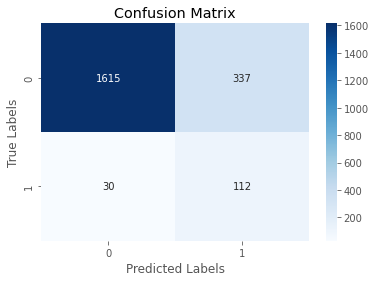

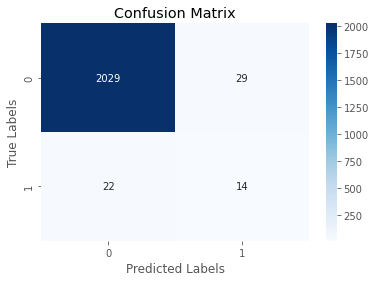

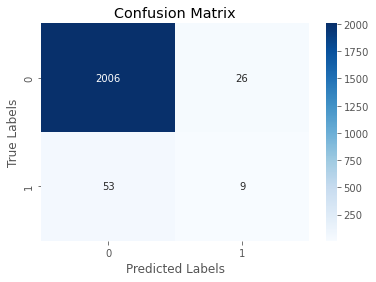

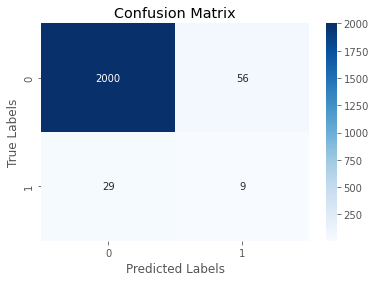

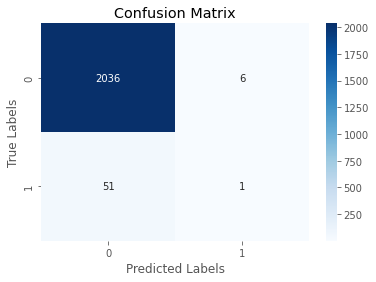

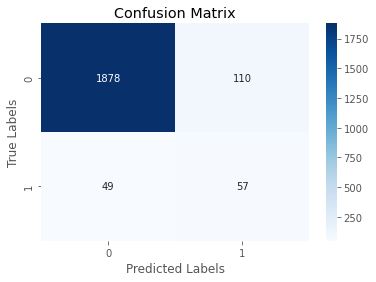

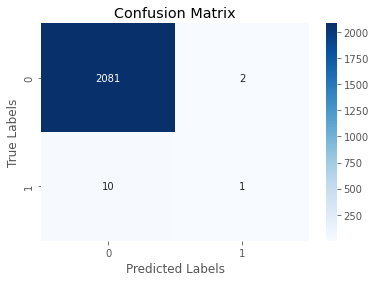

In [81]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

y_pred = evaluate(model, test_iter)

In [55]:
# Save preprocessed data, cropped to max length of the model.
tedf1['text'] = tedf1['text'].apply(lambda x: " ".join(x.split()[:512]))
tedf1.to_csv(f"test_data.csv")


In [56]:


# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'text' : ('text', text_field), 'label1' : ('label1', label_field),
          'label2' : ('label2', label_field),'label3' : ('label3', label_field),
          'label4' : ('label4', label_field),'label5' : ('label5', label_field),
          'label6' : ('label6', label_field),'label7' : ('label7', label_field)}

# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data = TabularDataset(path=f"test_data.csv", format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False)


# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [83]:
y_pred = evaluate(model, test_iter)

In [84]:
textfile = open("res/task2.txt", "w")
for element in y_pred:
    textfile.write(str(list(map(int, element)))[1:-1] + "\n")
textfile.close()


In [75]:
textfile = open("ref/task2.txt", "w")
for element in tedf1['label']:
    textfile.write(str(element)[1:-1] + "\n")
textfile.close()


In [69]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


In [85]:
!python evaluation.py . .

In [86]:
!cat scores.txt

task1_precision:0.36739659367396593
task1_recall:0.7587939698492462
task1_f1:0.4950819672131147
task2_unb:0.37901861252115066
task2_sha:0.35443037974683544
task2_pre:0.18556701030927839
task2_aut:0.17475728155339804
task2_met:0.03389830508474577
task2_com:0.4175824175824176
task2_the:0.14285714285714288
task2_avg:0.24115873566499552
